In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
BATCH_SIZE = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2022-11-03 08:21:04--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M  61.7MB/s    in 1.1s    

2022-11-03 08:21:06 (61.7 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH), #(150,150)
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH), #(150,150)
                                                              class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(PATH,batch_size=BATCH_SIZE,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode="binary",
                                                         shuffle=False,
                                                         classes=['test'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


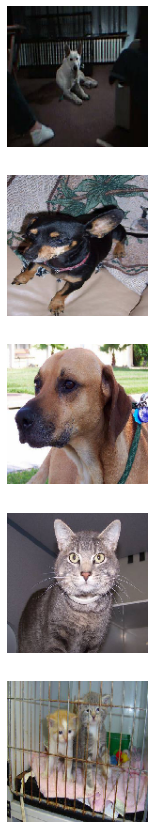

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)


Found 2000 images belonging to 2 classes.


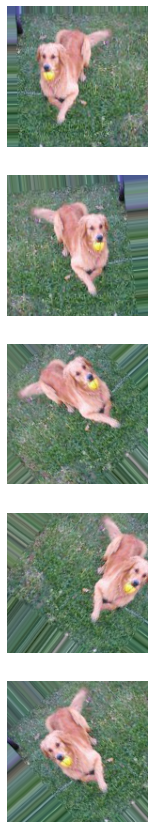

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [21]:
# 7
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [23]:
# 8
history = model.fit(train_data_gen, steps_per_epoch=total_train//BATCH_SIZE, 
                    epochs=epochs, validation_data=val_data_gen, 
                    validation_steps=total_val//BATCH_SIZE)

Epoch 1/15
15/15 [==============================] - 111s 8s/step - loss: 0.6929 - accuracy: 0.5059 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 115s 8s/step - loss: 0.6927 - accuracy: 0.5011 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 3/15
15/15 [==============================] - 111s 7s/step - loss: 0.6926 - accuracy: 0.4973 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 4/15
15/15 [==============================] - 115s 8s/step - loss: 0.6896 - accuracy: 0.5454 - val_loss: 0.6828 - val_accuracy: 0.5840
Epoch 5/15
15/15 [==============================] - 111s 7s/step - loss: 0.6848 - accuracy: 0.5572 - val_loss: 0.6891 - val_accuracy: 0.5030
Epoch 6/15
15/15 [==============================] - 108s 7s/step - loss: 0.6850 - accuracy: 0.5540 - val_loss: 0.6847 - val_accuracy: 0.5170
Epoch 7/15
15/15 [==============================] - 135s 9s/step - loss: 0.6847 - accuracy: 0.5262 - val_loss: 0.6725 - val_accuracy: 0.5810
Epoch 8/15
15

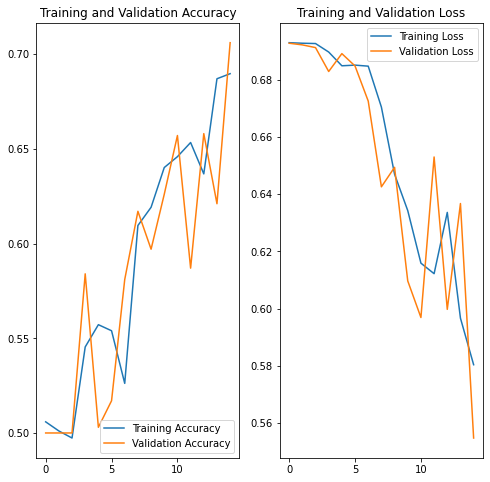

In [24]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 732ms/step


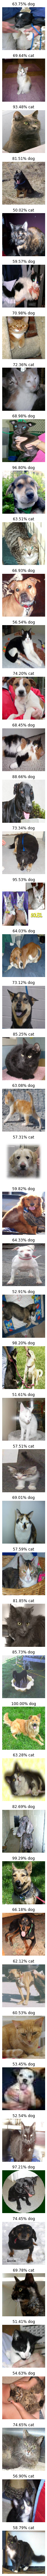

In [26]:
probabilities = model.predict(test_data_gen)[:,0]
plotImages(test_data_gen[0][0], probabilities)

In [27]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
